In [95]:
import pandas as pd
import numpy as np

FILE = "data_refined.csv"

df = pd.read_csv(FILE)

print(df.columns)
print(df.head(5))

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis'],
      dtype='object')
   radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0     1.097064     -2.073335        1.269934   0.984375         1.568466   
1     1.829821     -0.353632        1.685955   1.908708        -0.826962   
2     1.579888      0.456187        1.566503   1.558884         0.942210   
3    -0.768909      0.253732       -0.592687  -0.764

In [96]:
corrs = df.corrwith(df['diagnosis']).sort_values()
high_corr_vals = corrs[corrs.values > 0.7] # here we pick very highly-correlated values only
print(high_corr_vals)

area_mean               0.708984
radius_mean             0.730029
area_worst              0.733825
perimeter_mean          0.742636
radius_worst            0.776454
concave points_mean     0.776614
perimeter_worst         0.782914
concave points_worst    0.793566
diagnosis               1.000000
dtype: float64


In [97]:
df_hc = df[high_corr_vals.index]
print(df_hc.head(5)) # dataframe of highly correlated features

   area_mean  radius_mean  area_worst  perimeter_mean  radius_worst  \
0   0.984375     1.097064    2.001237        1.269934      1.886690   
1   1.908708     1.829821    1.890489        1.685955      1.805927   
2   1.558884     1.579888    1.456285        1.566503      1.511870   
3  -0.764464    -0.768909   -0.550021       -0.592687     -0.281464   
4   1.826229     1.750297    1.220724        1.776573      1.298575   

   concave points_mean  perimeter_worst  concave points_worst  diagnosis  
0             2.532475         2.303601              2.296076          1  
1             0.548144         1.535126              1.087084          1  
2             2.037231         1.347475              1.955000          1  
3             1.451707        -0.249939              2.175786          1  
4             1.428493         1.338539              0.729259          1  


In [98]:
from sklearn.model_selection import train_test_split
data_train, data_valid_test = train_test_split(df_hc, test_size=0.2, random_state=0)
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5, random_state=0)
target='diagnosis'
print("Training data set size: ", len(data_train.index))
print("Validation data set size: ", len(data_valid.index))
print("Testing data set size: ", len(data_test.index))
y_train = data_train[target]
x_train = data_train.drop(target, axis=1)
y_valid = data_valid[target]
x_valid = data_valid.drop(target, axis=1)
y_test = data_test[target]
x_test = data_test.drop(target, axis=1)


Training data set size:  455
Validation data set size:  57
Testing data set size:  57


In [99]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def hyperparam_grid_search(x_train, x_valid, y_train, y_valid):
    best_score = 0
    best_knn = None
    best_n = 0
    for n in range(1,16):
        knn = KNeighborsClassifier(n_neighbors=n).fit(x_train, y_train)
        score = knn.score(x_valid, y_valid)
        if score > best_score:
            best_score, best_knn, best_n = score, knn, n

    print("The best KNN classifier had score = %f with n_neighbors = %d"%(best_score, best_n))

    best_score = 0
    best_rfc = None
    best_n = 0
    best_depth = 0
    for n in range(1,16):
        for d in range(1,20):
            rfc = RandomForestClassifier(n_estimators=n, max_depth=d).fit(x_train, y_train)
            score = rfc.score(x_valid, y_valid)
            if score > best_score:
                best_score, best_rfc, best_n, best_depth = score, rfc, n, d

    print("The best Random Forest classifier had score = %f with n_estimators = %d and max_depth = %d"%(best_score, best_n, best_depth))

    kernels = {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}
    best_score = 0
    best_svm = None
    best_kernel = None
    for kernel in kernels:
        svm = SVC().fit(x_train, y_train)
        score = svm.score(x_valid, y_valid)
        if score > best_score:
            best_score, best_svm, best_kernel = score, svm, kernel

    print("The best Support Vector Machine classifier had score = %f with kernel = %s"%(best_score, best_kernel))
    return best_knn, best_rfc, best_svm

best_knn, best_rfc, best_svm = hyperparam_grid_search(x_train, x_valid, y_train, y_valid)


The best KNN classifier had score = 0.964912 with n_neighbors = 12


The best Random Forest classifier had score = 1.000000 with n_estimators = 3 and max_depth = 4
The best Support Vector Machine classifier had score = 0.947368 with kernel = sigmoid


Text(0.5, 1.0, 'KNN Classifier Confusion Matrix')

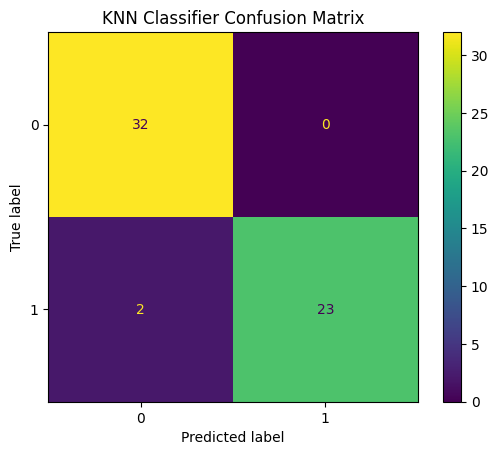

In [100]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = best_knn.predict(x_test)
fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
fig.plot()
fig.ax_.set_title("KNN Classifier Confusion Matrix")

Text(0.5, 1.0, 'Random Forest Classifier Confusion Matrix')

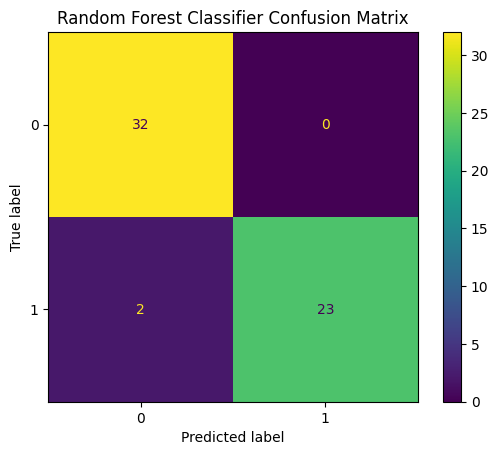

In [101]:
y_pred = best_rfc.predict(x_test)
fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
fig.plot()
fig.ax_.set_title("Random Forest Classifier Confusion Matrix")

Text(0.5, 1.0, 'SVM Classifier Confusion Matrix')

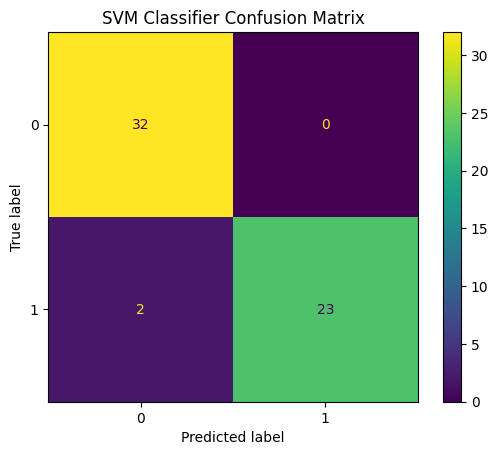

In [102]:
y_pred = best_svm.predict(x_test)
fig = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred))
fig.plot()
fig.ax_.set_title("SVM Classifier Confusion Matrix")

In [103]:
def print_test_scores(best_knn, best_rfc, best_svm):
    score_knn = best_knn.score(x_test, y_test)
    score_rfc = best_rfc.score(x_test, y_test)
    score_svm = best_svm.score(x_test, y_test)

    print("The best KNN Classifier test score is: ", score_knn)
    print("The best Random Forest Classifier test score is: ", score_rfc)
    print("The best SVM Classifier test score is: ", score_svm)

print_test_scores(best_knn, best_rfc, best_svm)

The best KNN Classifier test score is:  0.9649122807017544
The best Random Forest Classifier test score is:  0.9649122807017544
The best SVM Classifier test score is:  0.9649122807017544


In [104]:
''' For feature engineering, I'm going to take "mid-value" correlations between 0.2 and 0.7
and then sum those features, using their correlation values as weights. Hopefully, the resulting
"combination_feature" will be a useful feature
'''
corrs = df.corrwith(df['diagnosis'])
mid_corrs = corrs[(corrs.values > 0.2) & (corrs.values <= 0.7)]
corr_weights = mid_corrs / mid_corrs.sum()
df_mc = pd.DataFrame(df[mid_corrs.index])
for column in corr_weights.index:
    df_mc[column] = df_mc[column]*corr_weights[column]
sum_mc = df_mc.sum(axis='columns')
sum_mc.name = 'combination_feature'
df_new = pd.concat([df_hc, sum_mc], axis=1)
print(df_new.corrwith(df_new['diagnosis']).sort_values())

area_mean               0.708984
combination_feature     0.718294
radius_mean             0.730029
area_worst              0.733825
perimeter_mean          0.742636
radius_worst            0.776454
concave points_mean     0.776614
perimeter_worst         0.782914
concave points_worst    0.793566
diagnosis               1.000000
dtype: float64


In [105]:
data_train, data_valid_test = train_test_split(df_new, test_size=0.2, random_state=0)
data_valid, data_test = train_test_split(data_valid_test, test_size=0.5, random_state=0)
target='diagnosis'
y_train = data_train[target]
x_train = data_train.drop(target, axis=1)
y_valid = data_valid[target]
x_valid = data_valid.drop(target, axis=1)
y_test = data_test[target]
x_test = data_test.drop(target, axis=1)

best_knn, best_rfc, best_svm = hyperparam_grid_search(x_train, x_valid, y_train, y_valid)

The best KNN classifier had score = 0.947368 with n_neighbors = 2


The best Random Forest classifier had score = 1.000000 with n_estimators = 13 and max_depth = 3
The best Support Vector Machine classifier had score = 0.947368 with kernel = sigmoid


In [106]:
print_test_scores(best_knn, best_rfc, best_svm)

The best KNN Classifier test score is:  0.9473684210526315
The best Random Forest Classifier test score is:  0.9649122807017544
The best SVM Classifier test score is:  0.9473684210526315


In [ ]:
''' Despite it's rather high correlation with the target, the new combination_feature doesn't seem to improve
the accuracy of the prediction results. The lower-correlation values are likely just a bit too "noisy"
'''